hist [15 10 17  7  5  7 11 12 12  4]
bins [  0  10  20  30  40  50  60  70  80  90 100]
[37 12 72  9 75  5 79 64 16  1 76 71  6 25 50 20 18 84 11 28 29 14 50 68
 87 87 94 96 86 13  9  7 63 61 22 57  1  0 60 81  8 88 13 47 72 30 71  3
 70 21 49 57  3 68 24 43 76 26 52 80 41 82 15 64 68 25 98 87  7 26 25 22
  9 67 23 27 37 57 83 38  8 32 34 10 23 15 87 25 71 92 74 62 46 32 88 23
 55 65 77  3]


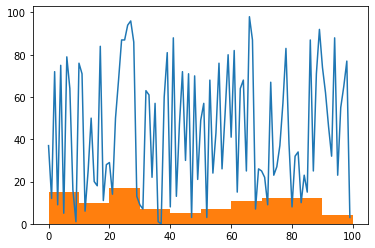

In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
# Creating dataset
a = np.random.randint(100, size =(100))
 
# Creating histogram
hist, bins = np.histogram(a, bins = [0, 10,
                                     20, 30,
                                     40, 50,
                                     60, 70,
                                     80, 90,
                                     100])
 
plt.plot(a)
# plt.stairs(hist, bins)
plt.hist(bins[:-1], bins, weights=hist)

print('hist', hist)
print('bins', bins)
print(a)

In [22]:
print(np.linspace(0, 93, 4))

[ 0. 31. 62. 93.]


shape: (277, 29376)


C:\Users\cuden\AppData\Local\Temp\ipykernel_12580\591044138.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ma == []:


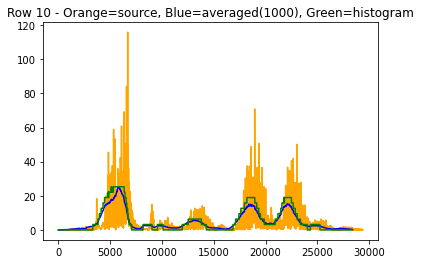

In [104]:
import numpy as np
from scipy.io import wavfile
from ssqueezepy import ssq_cwt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import sys

def scaler(array, min_, max_):
    array = array.reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(min_, max_))
    s_data = scaler.fit_transform(array)
    s_data = np.squeeze(s_data)
    return s_data

# Get wavelet from .wav file
def wav_to_wavelet(path):
    '''
    path: Direction to .wav file
    '''
    sample_rate, x = wavfile.read(path) 
    twx, wx, *_ = ssq_cwt(x)  # use wx
    print(f'shape: {wx.shape}')
    return np.abs(wx)

# Moving average function
def moving_average(array, window):
    '''
    array: short array have window length
    window: predefine value
    '''
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

# Moving average for wavelet
def wavelet_to_moving_average(matrix, window):
    '''
    matrix: a set of short array
    window: predefine value
    '''
    ma = []
    for i in matrix:
        i = moving_average(i, window)
        i = np.expand_dims(i, axis=0)
        if ma == []:
            ma = i
        else:
            ma = np.concatenate((ma, i), axis=0)
    return ma


def stairway(ma_row, bins, max_excursion):
    '''
    value: wavelet
    max_excursion: highest chosen value in stairway
    steps: number of bins
    '''
    range_ = np.linspace(0, max_excursion, bins).tolist()
    min_ma = np.min(ma_row)
    max_ma = np.max(ma_row)
    
    if max_ma > range_[-1]:
        range_[-1] = max_ma
    pair_ = [range_[i:i+2] for i in range(bins-1)]

    ma_hist = []
    for va in ma_row:
        for each_pair in pair_:
            if each_pair[0] < va < each_pair[1]:
                ma_hist.append(pair_.index(each_pair))
    
    ma_hist = np.array(ma_hist)
    ma_hist = ma_hist.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(min_ma, max_ma))
    ma_hist = scaler.fit_transform(ma_hist)
    ma_hist = ma_hist.reshape(-1, )
    return ma_hist    

# Plot a chosen row in the matrix
def plot_row(row, ax, c, matrix=None, option=None, hist=None, width=None):
    if np.max(matrix) != None:
        get = matrix[row]

    if np.max(hist) != None:
        # ax.bar(hist, hist, color=c, width=width)
        ax.plot(hist, c=c)
    else:
        ax.plot(get, c=c)



# parameters -----------------------------------------------------------
wav_file = 'wav/apple_and_lemmon.wav'
row = 10
window = 1000
max_excursion = 20
bins = 10

# computing part -------------------------------------------------------
wavelet = wav_to_wavelet(wav_file)
ma = wavelet_to_moving_average(wavelet, window)
ma_hist = stairway(ma[row], bins, max_excursion)

# Plot part -------------------------------------------------------------
fig = plt.figure()  
ax = fig.add_subplot()
plot_row(row, ax, 'orange', matrix=wavelet)
plot_row(row, ax, 'b', matrix=ma)
plot_row(row, ax, 'g', hist=ma_hist, width=0.4)

ax.set_title(f'Row {row} - Orange=source, Blue=averaged({window}), Green=histogram')
plt.show()


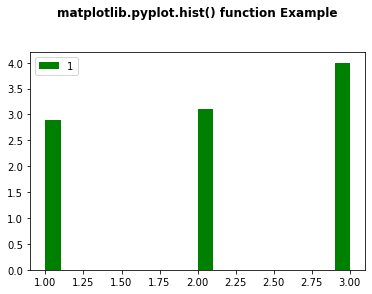

In [68]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random

list = np.array([random.randrange(1, 4) for _ in range(100)]).reshape(-1, 1)
    
np.random.seed(10**7)
n_bins = 20
x = np.random.randn(10000, 3)
    
colors = ['green']
  
plt.hist(list, 20, density = True, 
         histtype ='bar',
         color = colors,
         label = [1, 2, 3])
  
plt.legend(prop ={'size': 10})
  
plt.title('matplotlib.pyplot.hist() function Example\n\n',
          fontweight ="bold")
  
plt.show()

In [74]:

import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data_ = {'C':20, 'C++':15, 'Java':30,'Python':35}
print(data_)
courses = list(data_.keys())
values = list(data_.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

{'C': 20, 'C++': 15, 'Java': 30, 'Python': 35}


TypeError: 'numpy.ndarray' object is not callable

In [62]:
list


array([2, 3, 2, 1, 1, 3, 2, 3, 2, 3, 1, 1, 2, 2, 1, 1, 1, 3, 1, 2, 3, 3,
       2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 3, 1, 3, 2, 3,
       2, 2, 1, 3, 2, 1, 2, 1, 2, 3, 1, 3, 1, 2, 3, 3, 2, 3, 3, 3, 1, 2,
       3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 1, 1, 3, 2, 1, 2, 1, 2, 2, 3, 2, 2,
       2, 3, 3, 3, 3, 1, 3, 1, 2, 1, 1, 2])